In [2]:
using Distributed

In [6]:
using PWS
using Plots
using Statistics
using StatsFuns
using KernelDensity
using Distributions

┌ Info: Precompiling PWS [e595aebf-dd45-48e4-a6c3-f40ecff26dc3]
└ @ Base loading.jl:1278
┌ Info: Precompiling KernelDensity [5ab0869b-81aa-558d-bb23-cbf5423bbe9b]
└ @ Base loading.jl:1278


In [7]:
system = System()
t = PWS.time_matrix(200, 64)
initial = GaussianProposal(rand(joint(system, t)))

GaussianProposal{Array{Float64,1}}([-5.4358695922305715, -1.8065317017324953, -3.5840401579678405, -7.560948916086715, -3.848837422103178, 4.485901739344785, 9.612034429361739, 11.950903050555093, 19.83876918896692, 12.107645836532768  …  14.282798605859979, 15.826350251845426, 8.432930438261812, 24.31722845948419, 4.097111353416085, 0.22793202219051922, 7.0176106500364455, -1.9444572708194507, -2.310680221369347, 1.3967657338904371])

In [13]:
mean_s = system.κ / system.λ
mean_x = mean_s * system.ρ / system.μ

sigma_squared_ss = mean_s
sigma_squared_sx = system.ρ * mean_s / (system.λ + system.μ)
sigma_squared_xx = mean_x * (1 + system.ρ / (system.λ + system.μ))

sigma_squared_ss, sigma_squared_sx, sigma_squared_xx

(50.0, 33.333333333333336, 83.33333333333334)

In [3]:
signal_part(conf::PWS.SystemConfiguration) = conf.state[begin:length(conf.state) ÷ 2]
response_part(conf::PWS.SystemConfiguration) = conf.state[length(conf.state) ÷ 2 + 1 : end]

response_part (generic function with 1 method)

In [4]:
min_pot = -log_likelihood(system, t, signal=signal_part(initial), response=response_part(initial))

668.4838175473557

In [20]:
function dos_distributions(system::System, dim::Integer, Δt::Real, initial=nothing)
    t = PWS.time_matrix(dim, Δt)
    if initial == nothing
        initial = GaussianProposal(rand(joint(system, t)))
    else 
        initial = GaussianProposal(initial)
    end
    
    response = response_part(initial)
    signals = rand(prior(system, t), 100_000);

    samples = hcat(vcat.(eachcol(signals), Ref(response))...)

    sample_energies = -log_likelihood(system, t, signal=signals, response=response)
    kdestimate = kde(sample_energies)

    weight(e) = 1 / (exp(e - minimum(kdestimate.x)) + exp(e - maximum(kdestimate.x)))

    norm = sum(weight.(kdestimate.x) .* kdestimate.density .* diff(kdestimate.x)[begin])

    kdestimate.x, kdestimate.density, weight.(kdestimate.x), weight.(kdestimate.x) .* kdestimate.density ./ norm
end

dos_distributions (generic function with 2 methods)

In [9]:
import PyPlot; const plt = PyPlot
plt.svg(true)
using LaTeXStrings

In [10]:
plt.matplotlib.style.use("seaborn-whitegrid")

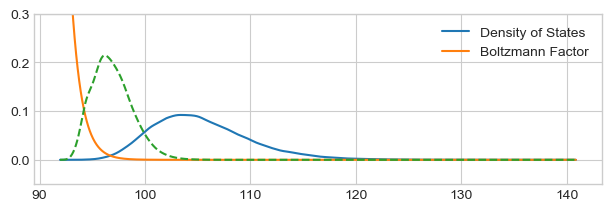

In [64]:
fig, axs = plt.subplots(1, 1, constrained_layout=true, sharey=true, figsize=(6, 2))
dims = [30]
for ((x, dens, weight, dens_weight), ax, dim) in zip(dos_distributions.(system, dims, 64.0), [axs], dims)
    ax.plot(x, dens, label="Density of States")
    ax.plot(x, weight, label="Boltzmann Factor")
    ax.set(ylim=(nothing, 0.3))
    ax.plot(x, dens_weight, "--", label="")
#     ax.set(title=latexstring("d=$dim"))
#     ax.set_xlabel(L"U=-\ln \mathrm{P}(\mathbf{x}|\mathbf{s})")
end
# axs[1].set(ylabel="density")
# axs[3].legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
axs.legend()
fig.savefig("normalized_densities.pdf")

In [57]:
dos_range, _ = dos_distributions(system, 200, 64.0, initial.state)
dos_range

662.2448178129478:0.059778250844369774:784.6108972913727

In [10]:
energy_bins = collect(range(dos_range[begin] * 0.96, dos_range[end], length=71));
energies = (energy_bins[begin+1:end] + energy_bins[begin:end-1]) ./ 2

70-element Array{Float64,1}:
 633.4546627448208
 635.3920821666121
 637.3295015884034
 639.2669210101949
 641.2043404319863
 643.1417598537777
 645.079179275569
 647.0165986973605
 648.9540181191519
 650.8914375409432
 652.8288569627346
 654.766276384526
 656.7036958063175
   ⋮
 745.8249892087213
 747.7624086305127
 749.699828052304
 751.6372474740954
 753.5746668958868
 755.5120863176783
 757.4495057394696
 759.3869251612609
 761.3243445830524
 763.2617640048438
 765.1991834266352
 767.1366028484265

In [12]:
wl = WangLandau(system, t, 1.0, 0.4, initial, energy_bins)

WangLandau{GaussianProposal{Array{Float64,1}}}(System(0.005, 0.25, 0.01, 0.01), [0.0 64.0 … 12672.0 12736.0; -64.0 0.0 … 12608.0 12672.0; … ; -12672.0 -12608.0 … 0.0 64.0; -12736.0 -12672.0 … -64.0 0.0], 1.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt64[0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000  …  0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000], 0.4, GaussianProposal{Array{Float64,1}}([15.632640438081978, 0.6109983419685339, -3.871074018126963, -14.211417751918006, -11.030546177468565, -5.810759556027085, -4.138915933204152, -4.0499602131867345, -7.498293253753253, -2.775683971539073  …  -14.987370626442372, -13.515

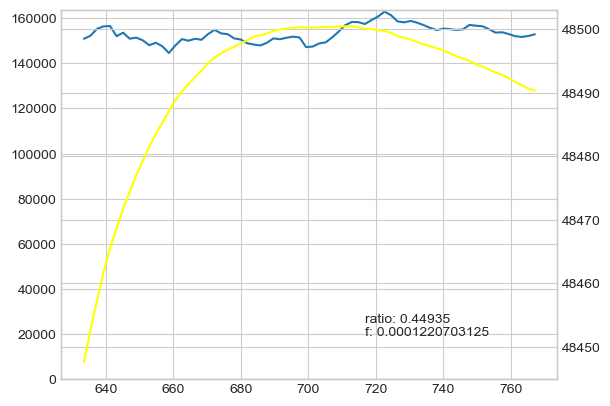

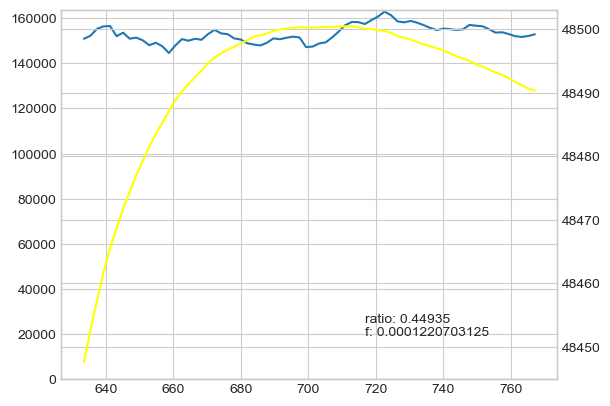

In [15]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

hist_list = []
entr_list = []
conf_list = []

for (accepted, rejected) in wl
    push!(hist_list, copy(wl.histogram))
    push!(entr_list, copy(wl.entropy))
    push!(conf_list, copy(wl.current_conf))
    IJulia.clear_output(true)
    fig.clear()
    ax = fig.subplots()
    ax2 = ax.twinx()
    ax.plot(energies, wl.histogram)
    ax2.plot(energies, wl.entropy, color="yellow")
    ax.set_ylim(0, nothing)
    
    fig.text(0.6, 0.2, "ratio: $(accepted / (accepted + rejected))\nf: $(wl.f_param)")
    
    display(fig)
end

In [16]:
hcat([conf.state for conf in conf_list]...)

400×441 Array{Float64,2}:
  -0.114114    2.31743      2.00376    …    3.0504     -3.88352     5.56764
  -5.48635    -2.34659     -0.0594274      -2.05275    -7.31014     3.57489
  -6.20451    -5.86997     -2.38952        -3.87673    -8.70041    -2.57658
 -10.8253     -5.07981     -6.43159        -5.20699    -6.32776    -8.36422
 -15.4098     -8.12154     -3.15958       -12.1403     -3.35848    -8.37918
  -7.51871    -1.34976     -5.66704    …   -8.44889    -6.52111   -10.9108
   1.41026    -0.0611774   -2.33007       -14.861     -14.322      -4.83855
   2.18279    -3.59874     -0.760185       -3.61284   -11.5868     -5.03061
   2.82909    -3.83951     -8.21206         0.436115  -11.1267     -9.65662
  10.2658     -4.04028     -6.38557        -6.68071   -10.9473     -5.18982
  15.1785     -7.18839     -9.65958    …  -11.1821    -11.2541     -7.46462
  11.6086     -3.77877     -5.35776       -12.5863    -12.8152     -9.50468
   0.807827   -4.1561      -4.77688        -9.0222    -12.528  

In [17]:
x, hist_dos, _ = dos_distributions(system, 200, 64.0, initial.state)

(659.4759406150014:0.052873048208738824:767.7070702982898, [3.2566248760190764e-9, 3.166694644354817e-9, 3.2036156540071747e-9, 3.366642053678759e-9, 3.658694987598854e-9, 4.0863326195017535e-9, 4.659779317614521e-9, 5.3930107705990604e-9, 6.3038917003099826e-9, 7.414362693247689e-9  …  1.4308730319307836e-8, 1.1947886045761066e-8, 9.977802003678302e-9, 8.34432357715506e-9, 7.001142461127499e-9, 5.909025490051165e-9, 5.0351263982881256e-9, 4.352379665874262e-9, 3.838975131060032e-9, 3.477911265188302e-9], [1.0, 0.9485004186663814, 0.8996530442103007, 0.8533212890880516, 0.8093755999569533, 0.7676930954175237, 0.7281572224108115, 0.6906574303116825, 0.6550888618056779, 0.6213520596863688  …  1.5939689825640102e-47, 1.5118802473031895e-47, 1.4340190475405073e-47, 1.3601676669678913e-47, 1.29011960157552e-47, 1.2236789822240856e-47, 1.1606600269527967e-47, 1.1008865214941862e-47, 1.044191326541412e-47, 9.904159103923334e-48], [0.011698952885707239, 0.01079003790926727, 0.01035367949505386

In [18]:
x

659.4759406150014:0.052873048208738824:767.7070702982898

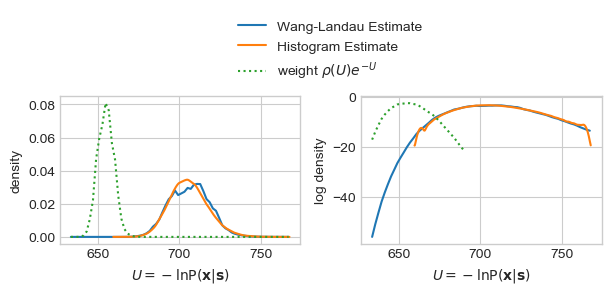

In [19]:
fig, (ax2, ax) = plt.subplots(1, 2, figsize=(6, 2), constrained_layout=true)
log_dos = wl.entropy .- logsumexp(wl.entropy .+ log.(diff(energy_bins)))
ax.plot(energies, log_dos)
ax.plot(x, log.(hist_dos))
ax.set(xlabel=L"U=-\ln\mathrm{P}(\mathbf{x}|\mathbf{s})", ylabel="log density")

ax2.plot(energies, exp.(log_dos), label="Wang-Landau Estimate")
ax2.plot(x, hist_dos, label="Histogram Estimate")
ax2.set(xlabel=L"U=-\ln\mathrm{P}(\mathbf{x}|\mathbf{s})", ylabel="density")

saved_ylim = ax2.get_ylim()

weight = exp.(log_dos) .* exp.(-(energies .- minimum(energies)))
ax2.plot(energies, weight / sum(weight .* diff(energy_bins)), ":", label=L"weight $\rho(U) e^{-U}$")
ax.plot(energies[begin:30], log.(weight[begin:30]) .- log(sum(weight .* diff(energy_bins))), ":")

# ax2.set_ylim(saved_ylim)

fig.legend(loc="lower center", bbox_to_anchor=(0.55, 1.0))
fig.savefig("wl_dos.svg", bbox_inches="tight")

In [20]:
sum(exp.(log_dos) .* exp.(-(energies .- minimum(energies))))

5.763921296950143e-18

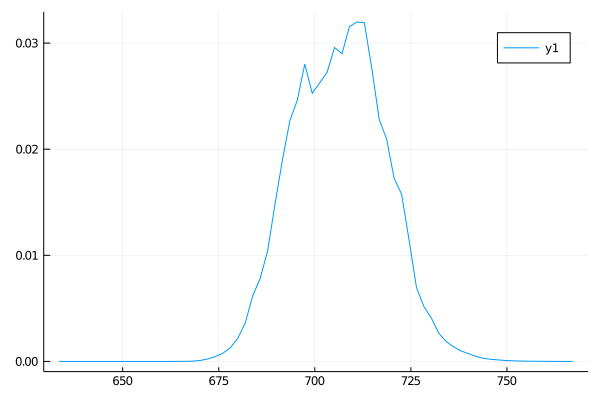

In [21]:
log_dos = wl.entropy .- logsumexp(wl.entropy .+ log.(diff(energy_bins)))
dos = exp.(log_dos)
plot(energies, dos)

In [22]:
estimate = logsumexp(-energies .+ log_dos .+ log.(diff(energy_bins)))

-672.4882195022836

In [23]:
true_val = logpdf(marginal(system, t), initial.state[size(t, 1) + 1:end])

-672.9188781835255

In [24]:
estimate / true_val - 1

-0.0006399860298234028

In [87]:
logsumexp(log_dos .+ log.(diff(energy_bins)))

-2.398081733190338e-14

In [27]:
window = []
anim = @animate for (hist, entr) in zip(hist_list, entr_list)
    pl1 = plot(energies, hist, ylims=(0,Inf), legend=false)
    pl2 = plot(energies, entr, linecolor=2, legend=false)
    
    for (index, hist) in enumerate(window)
        α = (index / (length(window) + 1))^2
        plot!(pl1, energies, hist, linecolor=1, linealpha=α)
    end
    
    push!(window, hist)
    if length(window) > 25
        popfirst!(window)
    end
    
    plot(pl1, pl2, layout=2)
end

Animation("/var/folders/51/t3h7r4z56mz2cf58m70c331m0000gn/T/jl_a2Wez8", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "033629.png", "033630.png", "033631.png", "033632.png", "033633.png", "033634.png", "033635.png", "033636.png", "033637.png", "033638.png"])

In [28]:
gif(anim, "anim_fps30.gif", fps = 60)

ProcessFailedException: failed process: Process(`/Users/mr/.julia/artifacts/dbb254dca678145c7d79410e96da494cc94f8a13/bin/ffmpeg -v 16 -framerate 60 -loop 0 -i /var/folders/51/t3h7r4z56mz2cf58m70c331m0000gn/T/jl_a2Wez8/%06d.png -i /var/folders/51/t3h7r4z56mz2cf58m70c331m0000gn/T/jl_a2Wez8/palette.bmp -lavfi paletteuse=dither=sierra2_4a -y /Users/mr/Git/PWS/anim_fps30.gif`, ProcessExited(255)) [255]


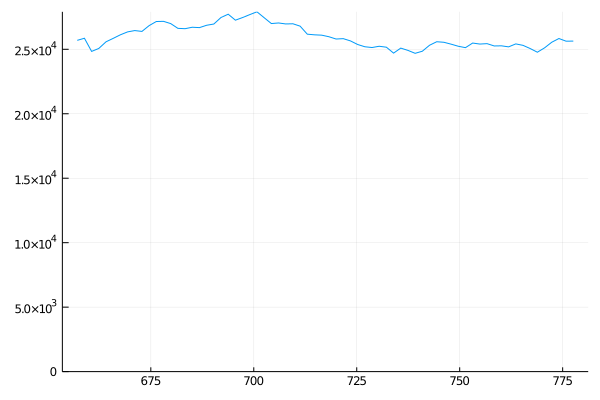

In [102]:
plot(energies, hist_list[end], ylims=(0,Inf), legend=false)